#### Exploratory Data Analysis of the Yield Curve

The following notebook will examine some of the elements of the yield curve and perform certain basis statistical tests to check for seasonality. 

In [1]:
!pip install pmdarima

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

zsh:1: command not found: nvidia-smi


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf  
from datetime import date
from datetime import timedelta

import seaborn as sns
sns.set_palette("mako")
from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

plotsize = (15, 4)

/tmp/ipykernel_3028/3318403556.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('/workspaces/capstone/Notebooks/Principal Component Analysis/Data/T10Y2Y (1).csv') 
df.head()

,DATE,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


In [5]:
len(df)


11633

In [6]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index('DATE') 
df["T10Y2Y"] = pd.to_numeric(df['T10Y2Y'], errors='coerce')
type(df["T10Y2Y"][0])

/tmp/ipykernel_4513/2038346711.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(df["T10Y2Y"][0])


numpy.float64

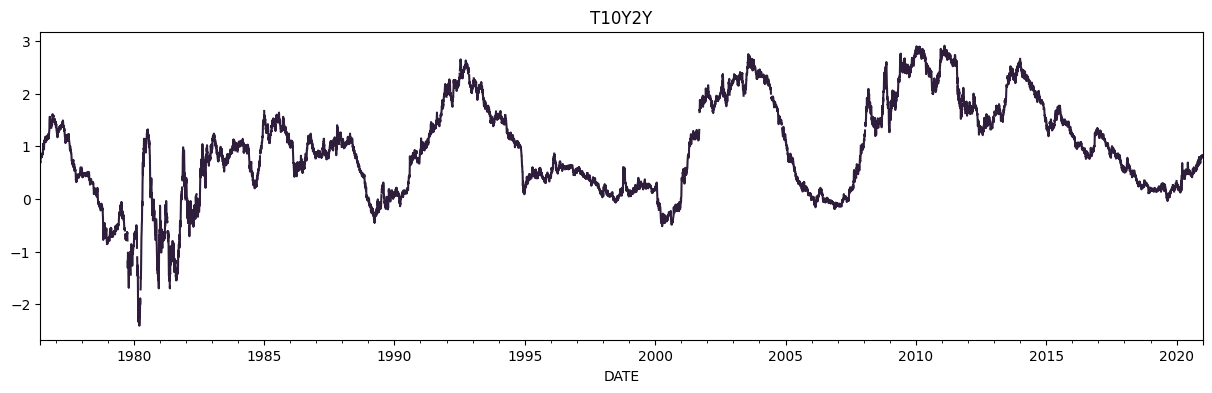

In [7]:
df["T10Y2Y"].plot(figsize = plotsize, title = "T10Y2Y")
plt.show()

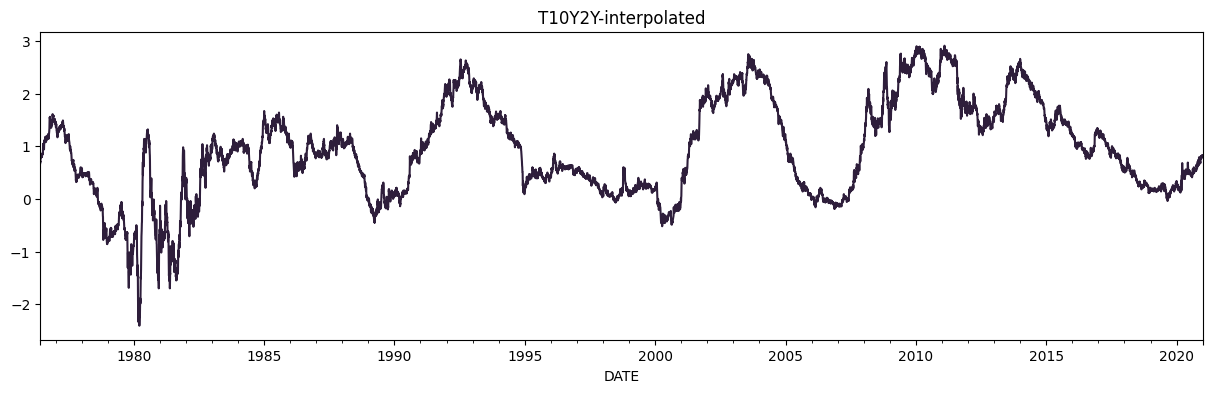

In [8]:
df["T10Y2Y"] = df.interpolate(method='time')
df["T10Y2Y"].plot(figsize = plotsize, title = "T10Y2Y-interpolated")
plt.show()

In [9]:
df.describe()

,T10Y2Y
count,11633.000000
mean,0.926040
std,0.910528
min,-2.410000
25%,0.240000
50%,0.870000
75%,1.560000
max,2.910000


In [10]:
df_weekly = df.resample('W').mean()
df_monthly = df.resample('M').mean()
df_quarterly = df.resample('Q').mean()
df_yearly = df.resample('Y').mean()

/tmp/ipykernel_4513/1388234944.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()
/tmp/ipykernel_4513/1388234944.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_quarterly = df.resample('Q').mean()
/tmp/ipykernel_4513/1388234944.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y').mean()


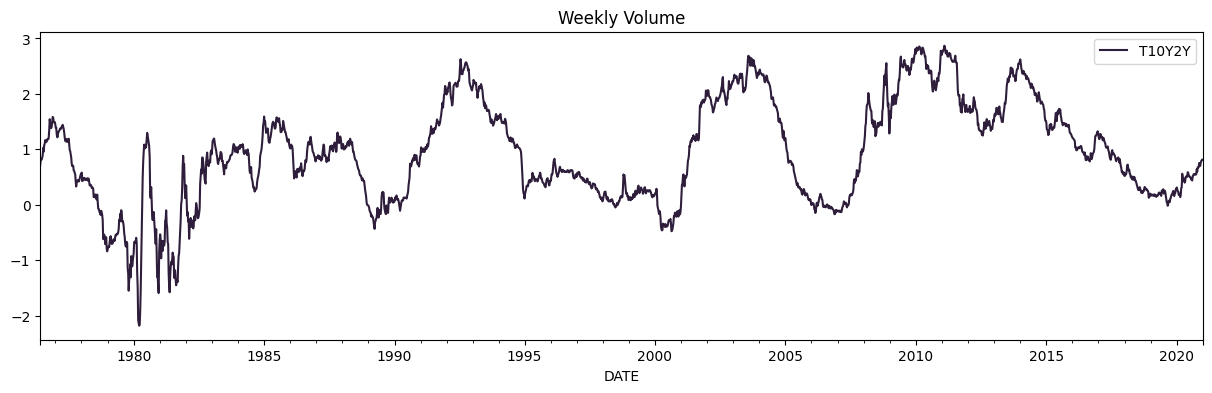

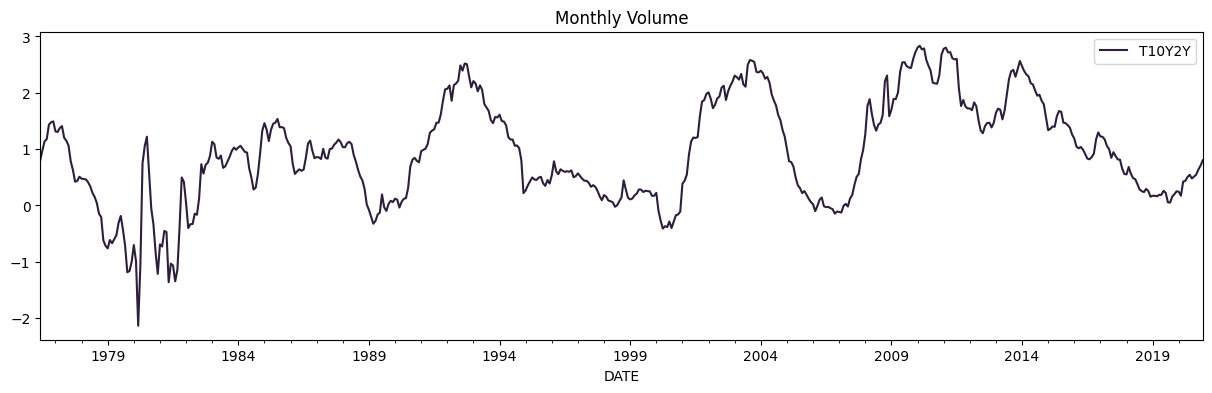

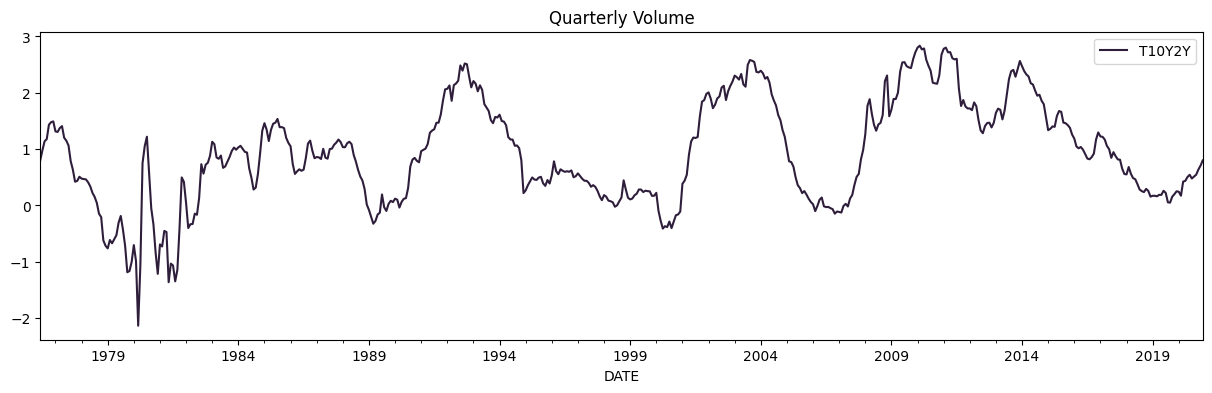

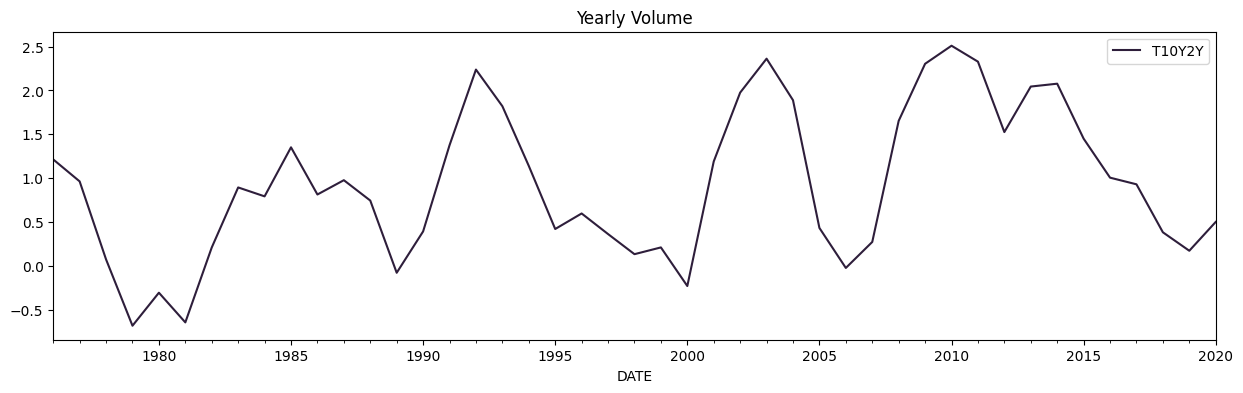

In [11]:
df_weekly.plot(figsize=plotsize, title='Weekly Volume')
plt.show()
df_monthly.plot(figsize=plotsize, title='Monthly Volume')
plt.show()
df_monthly.plot(figsize=plotsize, title='Quarterly Volume')
plt.show()
df_yearly.plot(figsize=plotsize, title='Yearly Volume')
plt.show()

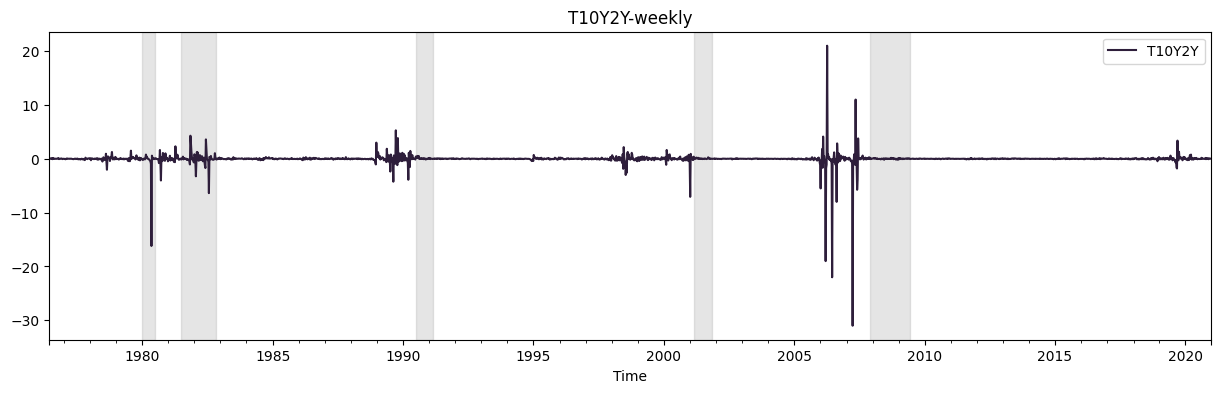

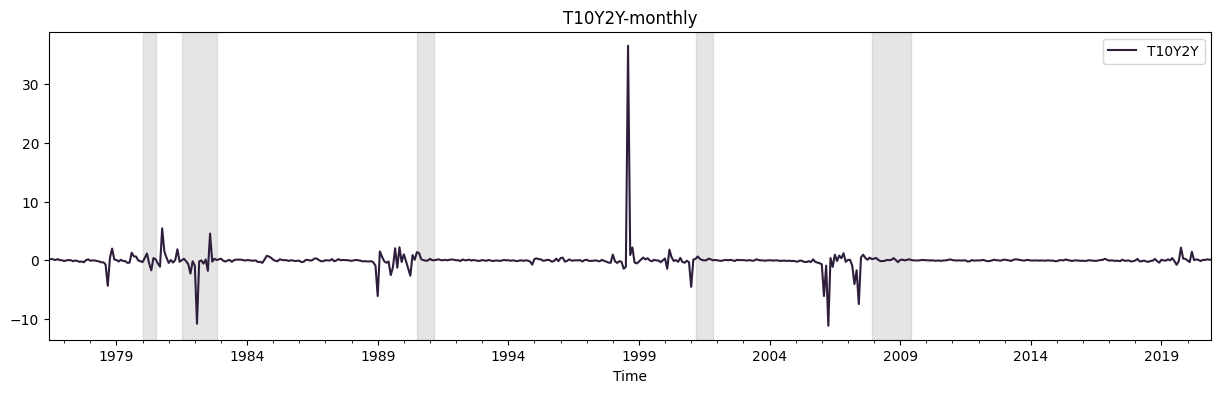

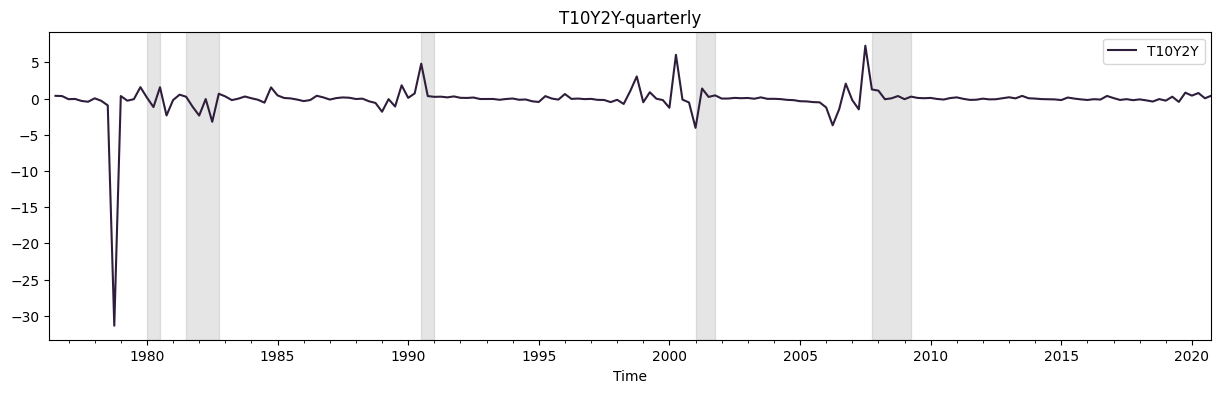

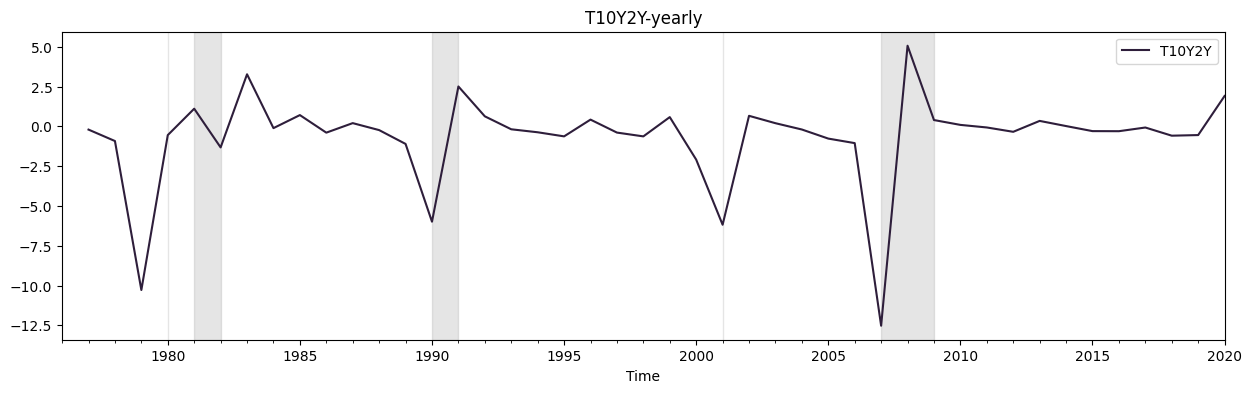

In [12]:
weekly_returns = df_weekly.pct_change()
weekly_returns.plot(figsize = plotsize, title = "T10Y2Y-weekly")

recession_periods = [('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'), ('1990-07-01', '1991-03-01'),
                     ('2001-03-01', '2001-11-01'), ('2007-12-01', '2009-06-01')]

for period in recession_periods:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

# display the chart
plt.xlabel("Time")
plt.show()

monthly_returns = df_monthly.pct_change()
monthly_returns.plot(figsize = plotsize, title = "T10Y2Y-monthly")

for period in recession_periods:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

# display the chart
plt.xlabel("Time")
plt.show()

quarterly_returns = df_quarterly.pct_change()
quarterly_returns.plot(figsize = plotsize, title = "T10Y2Y-quarterly")

for period in recession_periods:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

# display the chart
plt.xlabel("Time")
plt.show()

yearly_returns = df_yearly.pct_change()
yearly_returns.plot(figsize = plotsize, title = "T10Y2Y-yearly")

for period in recession_periods:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

# display the chart
plt.xlabel("Time")
plt.show()

### Stationarity analysis

In [13]:
# Define a function to perform stationarity testing
def stationarity_test(data):
    # Augmented Dickey-Fuller (ADF) test
    result_adf = adfuller(data)
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
    result_kpss = kpss(data)
    print('\nKPSS Statistic: %f' % result_kpss[0])
    print('p-value: %f' % result_kpss[1])
    print('Critical Values:')
    for key, value in result_kpss[3].items():
        print('\t%s: %.3f' % (key, value))

# Perform stationarity testing on the data

stationarity_test(df["T10Y2Y"])

ADF Statistic: -3.093134
p-value: 0.027066
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

KPSS Statistic: 2.696753
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/tmp/ipykernel_4513/4057265766.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(data)


### Trends, Seasonal, Residual Decomposition


In [14]:
#@title Default title text
data_transformed = df["T10Y2Y"] + np.abs(df["T10Y2Y"].min()) + 1

# Take logarithm of transformed data
data_transformed = np.log(data_transformed)

decomp = sm.tsa.seasonal_decompose(data_transformed, model='additive')

# Obtain components and transform back to original scale
trend = np.exp(decomp.trend) - np.abs(df["T10Y2Y"].min()) - 1
seasonal = np.exp(decomp.seasonal) - np.abs(df["T10Y2Y"].min()) - 1
residual = np.exp(decomp.resid) - np.abs(df["T10Y2Y"].min()) - 1

In [15]:
# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df["T10Y2Y"], model='additive', period=365)

# Extract the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

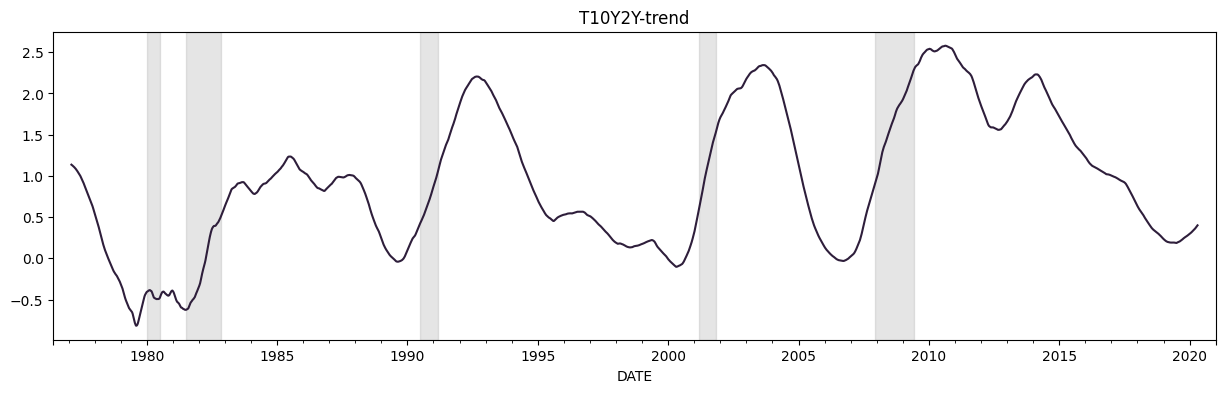

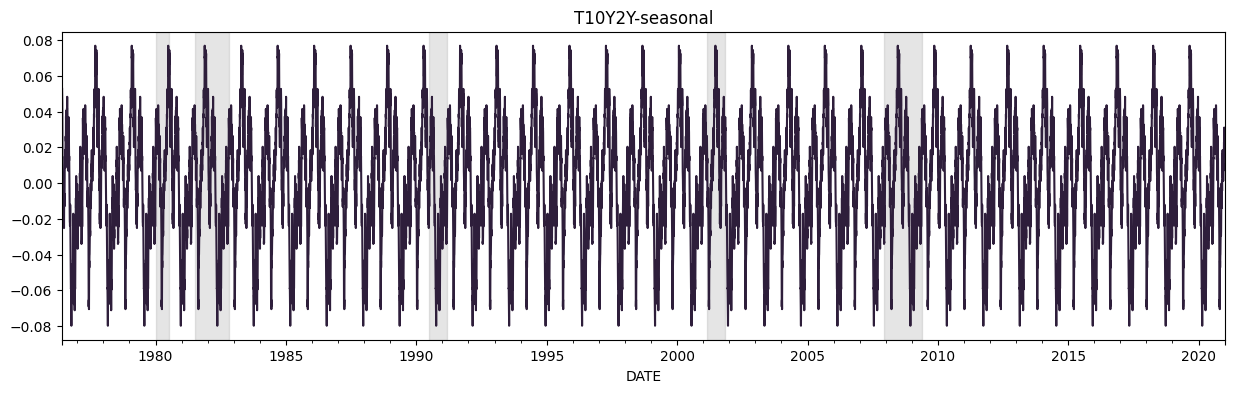

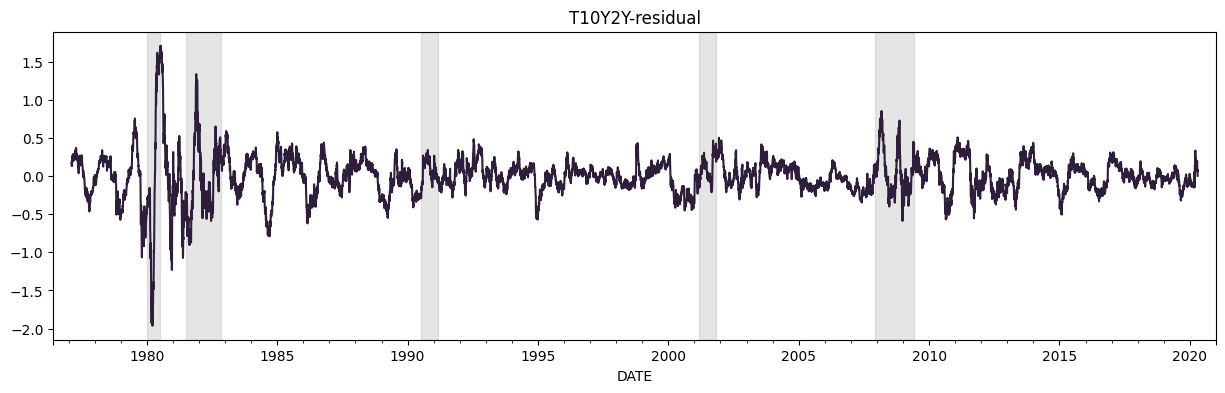

In [16]:
trend.plot(figsize = plotsize, title = "T10Y2Y-trend")

recession_periods = [('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'), ('1990-07-01', '1991-03-01'),
                     ('2001-03-01', '2001-11-01'), ('2007-12-01', '2009-06-01')]

for period in recession_periods:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

plt.show()

seasonal.plot(figsize = plotsize, title = "T10Y2Y-seasonal")

recession_periods = [('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'), ('1990-07-01', '1991-03-01'),
                     ('2001-03-01', '2001-11-01'), ('2007-12-01', '2009-06-01')]

for period in recession_periods:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

plt.show()

residual.plot(figsize = plotsize, title = "T10Y2Y-residual")

recession_periods = [('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'), ('1990-07-01', '1991-03-01'),
                     ('2001-03-01', '2001-11-01'), ('2007-12-01', '2009-06-01')]

for period in recession_periods:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

plt.show()
     


### Arima modelling

Autoregressive Integrated Moving Average (ARIMA): This is a widely used model for time-series data that exhibits a certain degree of correlation and/or seasonality. The model assumes that the current value of the time-series is a function of its past values and some random error term. The ARIMA model can be used for both short-term and long-term forecasting.



In [76]:
model = auto_arima(df["T10Y2Y"], start_p=0, start_d=0, start_q=0,
                   max_p=5, max_d=2, max_q=5, seasonal=False,
                   trace=True, error_action='ignore', suppress_warnings=True)
                   
# Print the selected (p,d,q) values
print(model.order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41172.519, Time=3.95 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41183.189, Time=3.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-41182.730, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41174.418, Time=2.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-41184.414, Time=3.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-41199.258, Time=3.73 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-41197.261, Time=4.83 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-41197.245, Time=3.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-41182.656, Time=13.53 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-41195.257, Time=3.89 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-41201.160, Time=2.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-41186.322, Time=1.57 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-41199.163, Time=2.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-41199.146, Time=2.44 sec
 ARI

In [77]:
# Fit ARIMA model
model = ARIMA(df["T10Y2Y"][-3650:], order=model.order)
results = model.fit()

# Predict future values
forecast = results.predict(start=date.today(), end=date.today() + timedelta(days=30))

/Users/ashutoshfatania/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/ashutoshfatania/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/ashutoshfatania/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


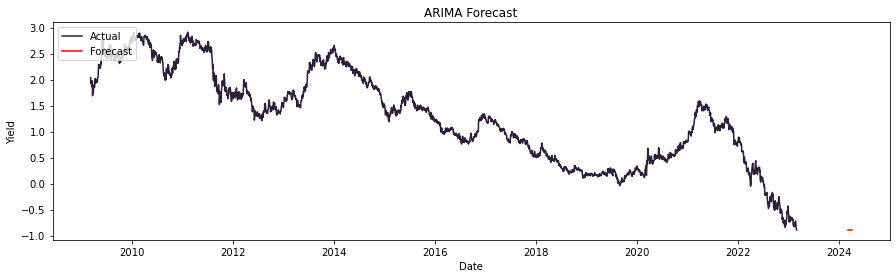

In [78]:
plt.figure(figsize=plotsize)
plt.plot(df["T10Y2Y"][-3650:], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast', color="red")
plt.legend(loc='upper left')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.show()
     


/Users/ashutoshfatania/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<AxesSubplot:>

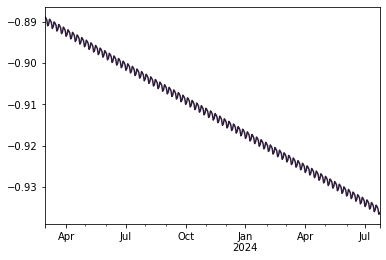

In [79]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the time-series data into a Pandas dataframe
ets_data = df.copy()

# Fit the ETS model
model = ExponentialSmoothing(ets_data, trend='add', seasonal='add')
result = model.fit()

# Make a forecast
forecast = result.forecast(steps=365)

# Plot the forecast
forecast.plot()